# Identifying pneumonia in X-ray images
Maciej Lorens

In [8]:
import os
from pathlib import Path
import glob
from tqdm import tqdm
from joblib import dump, load
import warnings
import numpy as np
import pandas as pd

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import  models, transforms
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

# Sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    log_loss,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Hyperparameter optimization
import optuna as opt
from optuna.integration import PyTorchLightningPruningCallback

# Image processing
from PIL import Image
from skimage.io import imread
import cv2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style="darkgrid")
import plotly.figure_factory as ff

# Shapley
import shap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data exploration

In [9]:
# Path to the images of X-rays
data_dir = Path("chest_xray")

# Path to the train directory
train_dir = data_dir / "train"

# Path to test directory
test_dir = data_dir / "test"

In [10]:
# Get a dataframe of image paths and labels
def get_image_df(img_dir):
    # Paths to normal and pneumonia xrays
    normal_dir = img_dir / "NORMAL"
    pneumonia_dir = img_dir / "PNEUMONIA"

    # List of all the images seperated by class
    normal_cases = normal_dir.glob("*.jpeg")
    pneumonia_cases = pneumonia_dir.glob("*.jpeg")

    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))
    
    # Combine lists of both classes into a dataframe
    data = pd.DataFrame(data, columns=["Image_dir", "Label"])

    return data

In [11]:
# Create both dataframes
train_data = get_image_df(train_dir)
test_data = get_image_df(test_dir)

In [12]:
# Check if dataframe is correct
train_data.head()

,Image_dir,Label
0,chest_xray/train/NORMAL/NORMAL2-IM-0687-0001.jpeg,0
1,chest_xray/train/NORMAL/NORMAL2-IM-1067-0001-0...,0
2,chest_xray/train/NORMAL/NORMAL2-IM-1164-0001.jpeg,0
3,chest_xray/train/NORMAL/IM-0651-0001.jpeg,0
4,chest_xray/train/NORMAL/IM-0652-0001-0002.jpeg,0


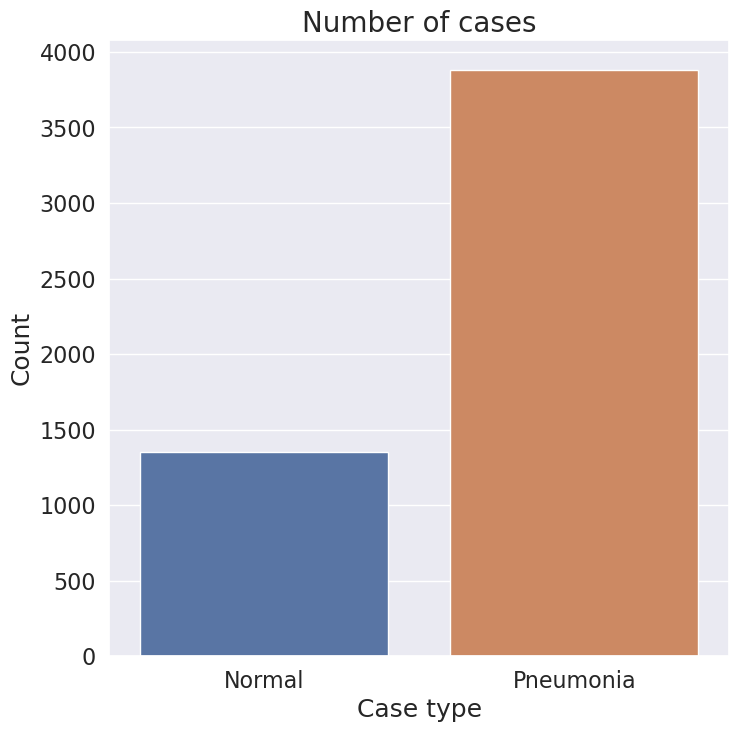

In [13]:
# Visualize imbalance between classes
# Get the counts for each class
cases_count = train_data['Label'].value_counts()

# Plot the results 
plt.figure(figsize=(8, 8))
sn.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=20)
plt.xlabel('Case type', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(fontsize=16)
plt.show()

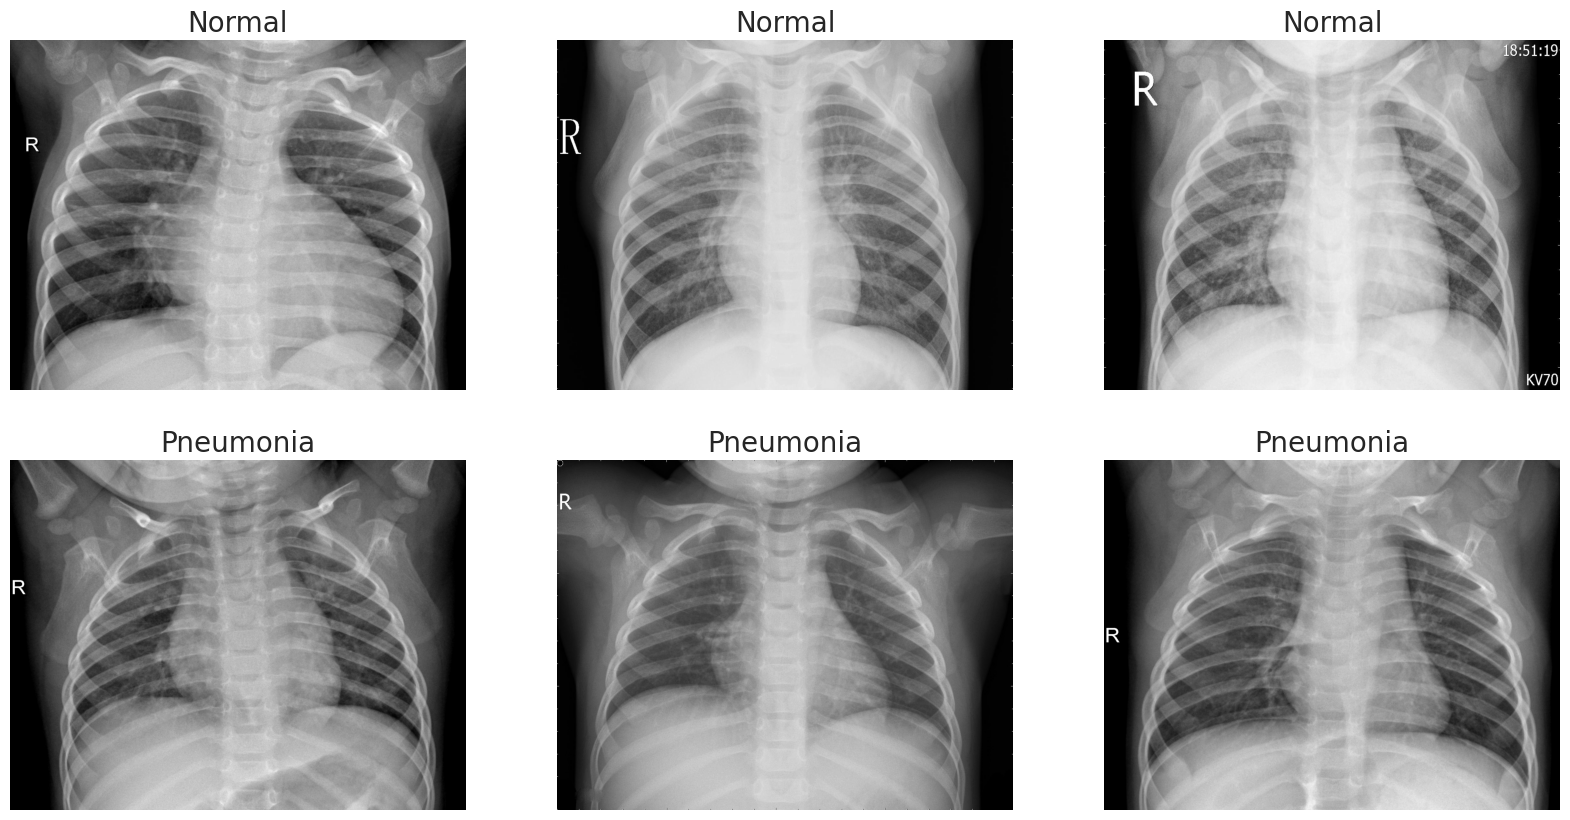

In [14]:
# Get three examples from each class and concatenate them
samples = list(train_data[train_data['Label']==1]['Image_dir'].iloc[:3]) + list(train_data[train_data['Label']==0]['Image_dir'].iloc[:3])

# Plot the examples
f, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    img = imread(samples[i])
    ax[i//3, i%3].imshow(img, cmap='gray')
    if i<3:
        ax[i//3, i%3].set_title("Normal", fontsize=20)
    else:
        ax[i//3, i%3].set_title("Pneumonia", fontsize=20)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()

In [15]:
# Splitting train data into train and validation set
train_data, val_data = train_test_split(train_data, test_size=0.3, shuffle=True, stratify=train_data["Label"], random_state=42)
train_data, val_data = train_data.reset_index(drop=True), val_data.reset_index(drop=True)

In [16]:
print(f"Pneumonia cases in the trainining set: {train_data['Label'].value_counts()[1]}, Normal cases in the trainining set: {train_data['Label'].value_counts()[0]}")
print(f"Pneumonia cases in the validation set: {val_data['Label'].value_counts()[1]}, Normal cases in the validation set: {val_data['Label'].value_counts()[0]}")

Pneumonia cases in the trainining set: 2718, Normal cases in the trainining set: 944
Pneumonia cases in the validation set: 1165, Normal cases in the validation set: 405


# Modeling

## Dataset and Dataloader

In [17]:
# Custom PyTorch dataset of images
class ImageDataset(Dataset):
    def __init__(self, data, transform, device=device, normalize=True):
        self.data = data
        self.transform = transform
        self.device = device
        self.normalize = normalize
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_dir = self.data.Image_dir[index]
        # Open image from path
        image = Image.open(image_dir)
        label = self.data.Label[index]
        # Apply provided transformations on the images
        image = self.transform(image)
        # If image is greyscale then dstack
        if image.shape[0] == 1:
            image = torch.cat((image, image, image), dim=0)
        # Normalizing pipeline
        post_transform = transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x * (1 / 255))
            , torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        if self.normalize:
            image = post_transform(image)

        return (image, torch.tensor(label).to(torch.float32).to(self.device))

In [18]:
# PyTorch Lightning dataloader
class PneumoniaDataLoader(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage):
        # Data transformations for training
        train_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.ToTensor()
        ])

        # Data transformations for validation and testing
        test_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.ToTensor()
        ])

        # Create three instances of the custom dataset class
        self.image_train = ImageDataset(self.train_data, transform=train_transforms)
        self.image_val = ImageDataset(self.val_data, transform=test_transforms)
        self.image_test = ImageDataset(self.test_data, transform=test_transforms)

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.image_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          , persistent_workers=True
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.image_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          , persistent_workers=True
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.image_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          , persistent_workers=True
                          )

## PyTorch Models

In [19]:
# Benchmark simple CNN model class
class BenchmarkCNNModel(nn.Module):
    def __init__(self, dropout):
        super().__init__()  
        self.conv_block1 = self.conv_block(3, 32)
        self.conv_block2 = self.conv_block(32, 32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_block3 = self.conv_block(32, 64)
        self.conv_block4 = self.conv_block(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_block5 = self.conv_block(64, 128)
        self.conv_block6 = self.conv_block(128, 128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28800, 128),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.maxpool1(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.maxpool2(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.maxpool3(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    

# Transfer learning model with VGG16 for the stacking ensemble
class VGG16Model(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        # Import VGG16 model with weights
        self.vgg16 = models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        # Replace the last layer with a new fully-connected layer
        num_features = self.vgg16.classifier[-1].in_features
        features = list(self.vgg16.classifier.children())[:-1]
        self.fn = nn.Linear(num_features, 1)
        self.vgg16.classifier = nn.Sequential(*features)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.vgg16(x)
        x = self.fn(self.dropout(x))

        return x


# Transfer learning model with DenseNet169 for the stacking ensemble
class DenseNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Import Densenet169 model with weights
        self.densenet = models.densenet169(weights=torchvision.models.DenseNet169_Weights.DEFAULT)
        # Delete the last layer outputing probabilities of 1000 classes from ImageNet dataset
        self.densenet.classifier = nn.Sequential(nn.Identity())
    
    def forward(self, x):
        x = self.densenet(x)

        return x
    

# Meta Model for combining outputs of two other models
class MetaModel(nn.Module):
    def __init__(self, dropout, n_neurons, activ):
        super().__init__()
        self.fn1 = nn.Linear(2, n_neurons)
        self.fn2 = nn.Linear(n_neurons, 1)
        self.activ = activ()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.activ(self.fn1(x))
        x = self.activ(self.fn2(self.dropout(x)))

        return x

In [20]:
# Pneumonia classification model created with lightning
class PneumoniaModel(pl.LightningModule):
    def __init__(self, model, lr=0.01):
        super().__init__()
        # Model of choice
        self.model = model
        # Learning rate
        self.lr = lr
        # BCE with logits loss is recommended, because it is more computationally stable
        # Weight is the ratio of normal to pneumonia cases in the training set
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(0.35))

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = self.bce(y_pred.squeeze(), y)
        self.log("train_loss", train_loss, logger=True, prog_bar=True, on_step=False, on_epoch=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = self.bce(y_pred.squeeze(), y)
        self.log("val_loss", val_loss, logger=True, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = self.bce(y_pred.squeeze(), y)
        self.log("test_loss", test_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, _ = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

## Model training and validation

In [21]:
# Create seperate dataloaders for later

train_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
])

# Create three instances of the custom dataset class
image_train = ImageDataset(train_data, transform=train_transforms)
image_val = ImageDataset(val_data, transform=test_transforms)
image_test = ImageDataset(test_data, transform=test_transforms)

train_loader = DataLoader(image_train
                          , shuffle=False 
                          , batch_size=128
                          , drop_last=False
                          , num_workers=8
                          )

val_loader = DataLoader(image_val
                        , shuffle=False
                        , batch_size=128
                        , drop_last=False
                        , num_workers=8
                        )

test_loader = DataLoader(image_test
                         , shuffle=False
                         , batch_size=128
                         , drop_last=False
                         , num_workers=8
                         )

### Benchmark model

#### Training best model

In [16]:
# Initialize dataloader
pneumonia_loader = PneumoniaDataLoader(train_data=train_data
                                       , val_data=val_data
                                       , test_data=test_data
                                       , random_state=42
                                       , batch_size=128
                                       , num_workers=8
                                       , device=device
                                       )

In [17]:
pl.seed_everything(42, workers=True)
benchmark_model = PneumoniaModel(BenchmarkCNNModel(dropout=0.2).to(device), lr=0.001)
benchmark_trainer = pl.Trainer(max_epochs=20
                               , check_val_every_n_epoch=1
                               , log_every_n_steps=1
                               , deterministic=True
                               , default_root_dir="benchmark_logs/"
                               , callbacks=[EarlyStopping(monitor="val_loss", mode="min"), 
                                            ModelCheckpoint(monitor="val_loss", save_top_k=-1)])

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
benchmark_trainer.fit(benchmark_model, datamodule=pneumonia_loader)

Missing logger folder: benchmark_logs/lightning_logs

  | Name  | Type              | Params
--------------------------------------------
0 | model | BenchmarkCNNModel | 4.0 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.898    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### VGG16 Model

#### Hyperparameter tuning

In [15]:
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")
# Tuning hyperparameters with Optuna
def objective(trial):
    pl.seed_everything(42, workers=True)
    # Define grid search
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.4])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])

    vgg16_model = VGG16Model(dropout=dropout).to(device)
    vgg16_model.vgg16.requires_grad_(False)
    model = PneumoniaModel(vgg16_model, lr=lr)

    optuna_loader = PneumoniaDataLoader(train_data=train_data
                                        , val_data=val_data
                                        , test_data=test_data
                                        , random_state=42
                                        , batch_size=batch_size
                                        , num_workers=8
                                        , device=device
                                        )
    
    optuna_trainer = pl.Trainer(max_epochs=10
                                , enable_checkpointing=False
                                , logger=True
                                , log_every_n_steps=1
                                , check_val_every_n_epoch=1
                                , deterministic=True
                                , default_root_dir="vgg16_optuna_logs/"
                                , callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                                             EarlyStopping(monitor="val_loss", mode="min")])
    
    hyperparameters = dict(batch_size=batch_size, dropout=dropout, lr=lr)
    optuna_trainer.logger.log_hyperparams(hyperparameters)
    optuna_trainer.fit(model, datamodule=optuna_loader)

    return optuna_trainer.callback_metrics["val_loss"].item()

study = opt.create_study(direction="minimize", study_name="vgg16_model", pruner=opt.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(objective, n_trials=12, n_jobs=1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

[I 2024-01-18 11:30:50,714] A new study created in memory with name: vgg16_model
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-18 12:40:50,807] Trial 0 finished with value: 0.11055752635002136 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.11055752635002136.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-18 13:58:07,058] Trial 1 finished with value: 0.10073328763246536 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.001}. Best is trial 1 with value: 0.10073328763246536.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-18 15:15:30,070] Trial 2 finished with value: 0.10073328763246536 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.001}. Best is trial 1 with value: 0.10073328763246536.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-18 16:32:49,082] Trial 3 finished with value: 0.09511078149080276 and parameters: {'batch_size': 256, 'dropout': 0.4, 'lr': 0.01}. Best is trial 3 with value: 0.09511078149080276.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-18 17:42:09,079] Trial 4 finished with value: 0.11864274740219116 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.01}. Best is trial 3 with value: 0.09511078149080276.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-18 19:00:39,548] Trial 5 finished with value: 0.09552771598100662 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.001}. Best is trial 3 with value: 0.09511078149080276.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-18 20:18:21,336] Trial 6 finished with value: 0.0922253429889679 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.001}. Best is trial 6 with value: 0.0922253429889679.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-18 21:37:14,910] Trial 7 finished with value: 0.09140556305646896 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.001}. Best is trial 7 with value: 0.09140556305646896.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-18 22:47:16,930] Trial 8 finished with value: 0.11055752635002136 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.01}. Best is trial 7 with value: 0.09140556305646896.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-18 23:57:27,317] Trial 9 finished with value: 0.11055752635002136 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.01}. Best is trial 7 with value: 0.09140556305646896.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 01:15:28,936] Trial 10 pruned. Trial was pruned at epoch 9.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 02:33:24,110] Trial 11 finished with value: 0.09140556305646896 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.001}. Best is trial 7 with value: 0.09140556305646896.


Best hyperparameters:  {'batch_size': 64, 'dropout': 0.2, 'lr': 0.001}
Score on validation:  0.09140556305646896


#### Training the best model

In [16]:
# Initialize dataloader with batch size chosen with hyperparameter optimization
pneumonia_loader = PneumoniaDataLoader(train_data=train_data
                                       , val_data=val_data
                                       , test_data=test_data
                                       , random_state=42
                                       , batch_size=64
                                       , num_workers=8
                                       , device=device
                                       )

In [14]:
pl.seed_everything(42, workers=True)
# Use dropout chosen with hyperparameter optimization
vgg16_model = VGG16Model(dropout=0.2).to(device)
# Turn off training for VGG16
# Only the final fully connected layer is trainable
vgg16_model.vgg16.requires_grad_(False)
# Use learning rate chosen with hyperparameter optimization
vgg16_model_lightning = PneumoniaModel(vgg16_model, lr=0.001)
vgg16_trainer = pl.Trainer(max_epochs=20
                           , check_val_every_n_epoch=1
                           , log_every_n_steps=1
                           , deterministic=True
                           , default_root_dir="vgg16_logs/"
                           , callbacks=[EarlyStopping(monitor="val_loss", mode="min")])

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [18]:
# Train the model
vgg16_trainer.fit(vgg16_model_lightning, datamodule=pneumonia_loader)

Missing logger folder: vgg16_logs/lightning_logs

  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16Model        | 134 M 
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### Densenet169 and SVM Classifier

#### Initialize DenseNet169 with pretrained weights

In [22]:
pl.seed_everything(42, workers=True)
densenet_model = DenseNetModel().to(device)
densenet_model.densenet.requires_grad_(False)

Seed set to 42


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [33]:
# Get features extracted with Densenet169 that will serve as input to SVM
def get_densenet_predictions(dataloader, model):
    model.eval()
    cnn_preds_all = []

    for X, _ in tqdm(dataloader, total=len(dataloader)):
        cnn_preds = model(X)
        cnn_preds_all += [cnn_preds.detach().cpu().numpy()]
    
    cnn_preds_all = np.concatenate(cnn_preds_all, axis=0)
    
    return cnn_preds_all

In [26]:
svc_train_features = get_densenet_predictions(train_loader, densenet_model, device)
svc_val_features = get_densenet_predictions(val_loader, densenet_model, device)

100%|██████████| 13/13 [01:22<00:00,  6.37s/it]


In [27]:
# Saving and loading the features will save time when running the codes
# np.savetxt("svc_train_features.csv", svc_train_features, delimiter=",")
# np.savetxt("svc_val_features.csv", svc_val_features, delimiter=",")

svc_train_features = np.loadtxt("svc_train_features.csv", delimiter=",")
svc_val_features = np.loadtxt("svc_val_features.csv", delimiter=",")

#### SVM Classifier

##### Hyperparameter tuning

In [28]:
# Tuning SVC hyperparameters with Optuna
def objective(trial):
    # Define search space
    params = dict(
        C = trial.suggest_float("C", 1e-2, 1e-1),
        kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"]),
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    )

    svc_model = SVC(**params, probability=True, random_state=42)

    svc_pipe = Pipeline([("scaler", StandardScaler())
                     , ("model", svc_model)])

    svc_pipe.fit(svc_train_features, np.array(train_data["Label"]))

    score = log_loss(np.array(val_data["Label"]), svc_pipe.predict_proba(svc_val_features))

    return score

study = opt.create_study(direction="minimize", study_name="svc", pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

[I 2024-01-19 11:12:43,278] A new study created in memory with name: svc
[I 2024-01-19 11:18:01,123] Trial 0 finished with value: 0.30113306590543243 and parameters: {'C': 0.08881379602153497, 'kernel': 'poly', 'class_weight': None}. Best is trial 0 with value: 0.30113306590543243.
[I 2024-01-19 11:18:10,219] Trial 1 finished with value: 0.34736225389579256 and parameters: {'C': 0.04657360616184588, 'kernel': 'poly', 'class_weight': None}. Best is trial 0 with value: 0.30113306590543243.
[I 2024-01-19 11:18:14,061] Trial 3 finished with value: 0.23140991422578475 and parameters: {'C': 0.09183355818480396, 'kernel': 'rbf', 'class_weight': None}. Best is trial 3 with value: 0.23140991422578475.
[I 2024-01-19 11:18:30,027] Trial 4 finished with value: 0.23193285861049226 and parameters: {'C': 0.0895634531218461, 'kernel': 'rbf', 'class_weight': None}. Best is trial 3 with value: 0.23140991422578475.
[I 2024-01-19 11:18:43,024] Trial 7 finished with value: 0.2528186407257171 and parameters

Best hyperparameters:  {'C': 0.010027142259964428, 'kernel': 'linear', 'class_weight': 'balanced'}
Score on validation:  0.14837143882862985


##### Training SVM

In [29]:
# Use the best hyperparameters
svc_model = SVC(**study.best_params, probability=True, random_state=42)
# Scale the features extracted with Densenet169
svc_pipe = Pipeline([("scaler", StandardScaler())
                    , ("model", svc_model)])

In [30]:
# Train the model
svc_pipe.fit(svc_train_features, np.array(train_data["Label"]))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=0.010027142259964428, class_weight='balanced',
                     kernel='linear', probability=True, random_state=42))])

In [34]:
# Save the best model pipeline
dump(svc_pipe, 'svc_pipeline.joblib') 

['svc_pipeline.joblib']

### Stacking of the two models

In [25]:
# Add trainers here for convenience, when rerunning the codes
benchmark_trainer = pl.Trainer(logger=False
                               , deterministic=True)

vgg16_trainer = pl.Trainer(logger=False
                           , deterministic=True)

meta_trainer = pl.Trainer(logger=False
                          , deterministic=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
# Load best benchmark CNN model
best_benchmark = PneumoniaModel.load_from_checkpoint(checkpoint_path="benchmark_logs/lightning_logs/version_0/checkpoints/epoch=9-step=150.ckpt"
                                                     , model=BenchmarkCNNModel(dropout=0.4), lr=0.01)

# Load best vgg16 model
best_vgg16 = PneumoniaModel.load_from_checkpoint(checkpoint_path="vgg16_logs/lightning_logs/version_0/checkpoints/epoch=16-step=986.ckpt"
                                                 , model=VGG16Model(dropout=0.2), lr=0.001)

# Load SVM pipeline
svc_pipe = load("svc_pipeline.joblib")

#### Preparing input data for the meta-learner

In [39]:
# Get predictions of Densenet + SVM and VGG16 as input for the meta-learner
def get_meta_data(image_df, shuffle=False):
    image_transforms = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor()
    ])
    meta_loader = DataLoader(ImageDataset(image_df, transform=image_transforms)
                             , shuffle=shuffle
                             # Batch size doesn't matter here, since these models are not trained anymore
                             , batch_size=128
                             , drop_last=False
                             , num_workers=8
                             )
    
    # Get predictions from VGG16
    vgg16_preds = vgg16_trainer.predict(best_vgg16, dataloaders=meta_loader)
    vgg16_preds = np.hstack([torch.sigmoid(pred.squeeze(1)).detach().cpu().numpy() for pred in vgg16_preds])
    
    # Get predictions from Densenet169 + SVM
    svm_features = get_densenet_predictions(meta_loader, densenet_model, device)
    svm_preds = svc_pipe.predict_proba(svm_features)[:, 1]

    # Concatenate the two and return as input for the meta-learner
    return np.concatenate((vgg16_preds.reshape(-1, 1), svm_preds.reshape(-1, 1)), axis=1), np.array(image_df["Label"])

In [43]:
# Create new datasets with the meta-learner input data
X_train, y_train = get_meta_data(train_data)
X_val, y_val = get_meta_data(val_data)
X_test, y_test = get_meta_data(test_data)

meta_train_dataset = TensorDataset(torch.from_numpy(X_train).unsqueeze(1).to(torch.float32).to(device), torch.from_numpy(y_train).to(torch.float32).to(device))
meta_val_dataset = TensorDataset(torch.from_numpy(X_val).unsqueeze(1).to(torch.float32).to(device), torch.from_numpy(y_val).to(torch.float32).to(device))
meta_test_dataset = TensorDataset(torch.from_numpy(X_test).unsqueeze(1).to(torch.float32).to(device), torch.from_numpy(y_test).to(torch.float32).to(device))

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 29/29 [03:10<00:00,  6.57s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 13/13 [01:17<00:00,  5.96s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 5/5 [00:35<00:00,  7.02s/it]


In [48]:
# Saving te datasets here will save time when rerunning the codes
# torch.save(meta_train_dataset, 'meta_train_dataset.pt')
# torch.save(meta_val_dataset, 'meta_val_dataset.pt')
# torch.save(meta_test_dataset, 'meta_test_dataset.pt')

In [27]:
meta_train_dataset = torch.load('meta_train_dataset.pt')
meta_val_dataset = torch.load('meta_val_dataset.pt')
meta_test_dataset = torch.load('meta_test_dataset.pt')

#### Hyperparameter optimization

In [49]:
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")
# Tuning hyperparameters with Optuna
def objective(trial):
    pl.seed_everything(42, workers=True)
    # Define grid search
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.4])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])
    n_neurons = trial.suggest_categorical("n_neurons", [2, 4, 6, 8])
    activ = trial.suggest_categorical("activ", [nn.Identity, nn.Sigmoid, nn.ReLU])

    meta_model = MetaModel(dropout=dropout, n_neurons=n_neurons, activ=activ).to(device)
    model = PneumoniaModel(meta_model, lr=lr)
    
    optuna_train_loader = DataLoader(meta_train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)
    optuna_val_loader = DataLoader(meta_val_dataset, shuffle=False, batch_size=batch_size, num_workers=8)
    
    optuna_trainer = pl.Trainer(max_epochs=10
                                , enable_checkpointing=False
                                , logger=True
                                , log_every_n_steps=1
                                , check_val_every_n_epoch=1
                                , deterministic=True
                                , default_root_dir="meta_optuna_logs/"
                                , callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                                             EarlyStopping(monitor="val_loss", mode="min")])
    
    hyperparameters = dict(batch_size=batch_size, dropout=dropout, lr=lr, n_neurons=n_neurons, activ=activ)
    optuna_trainer.logger.log_hyperparams(hyperparameters)
    optuna_trainer.fit(model, train_dataloaders=optuna_train_loader, val_dataloaders=optuna_val_loader)

    return optuna_trainer.callback_metrics["val_loss"].item()

study = opt.create_study(direction="minimize", study_name="meta_model", pruner=opt.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(objective, n_trials=144, n_jobs=1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

[I 2024-01-19 13:18:30,901] A new study created in memory with name: meta_model
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:18:50,338] Trial 0 finished with value: 0.38149887323379517 and parameters: {'batch_size': 256, 'dropout': 0.4, 'lr': 0.001, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.activation.Sigmoid'>}. Best is trial 0 with value: 0.38149887323379517.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:19:10,610] Trial 1 finished with value: 0.28670617938041687 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.001, 'n_neurons': 4, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 1 with value: 0.28670617938041687.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:19:29,652] Trial 2 finished with value: 0.3301418721675873 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 4, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 1 with value: 0.28670617938041687.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:19:52,917] Trial 3 finished with value: 0.3584589958190918 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 4, 'activ': <class 'torch.nn.modules.activation.Sigmoid'>}. Best is trial 1 with value: 0.28670617938041687.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:20:13,169] Trial 4 finished with value: 0.35761862993240356 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.Sigmoid'>}. Best is trial 1 with value: 0.28670617938041687.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:20:32,265] Trial 5 finished with value: 0.29289841651916504 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 1 with value: 0.28670617938041687.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:20:52,905] Trial 6 finished with value: 0.320829302072525 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.001, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 1 with value: 0.28670617938041687.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:21:13,325] Trial 7 finished with value: 0.27984896302223206 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 4, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 7 with value: 0.27984896302223206.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:21:36,381] Trial 8 finished with value: 0.22589987516403198 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 8 with value: 0.22589987516403198.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:21:55,109] Trial 9 finished with value: 0.305124968290329 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.activation.Sigmoid'>}. Best is trial 8 with value: 0.22589987516403198.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:22:12,633] Trial 10 finished with value: 0.2214580625295639 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.2214580625295639.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:22:30,230] Trial 11 finished with value: 0.2214580625295639 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.2214580625295639.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:22:47,633] Trial 12 finished with value: 0.2214580625295639 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.2214580625295639.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:23:05,011] Trial 13 finished with value: 0.2214580625295639 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.2214580625295639.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:23:22,700] Trial 14 finished with value: 0.2214580625295639 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.2214580625295639.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:23:40,333] Trial 15 finished with value: 0.2214580625295639 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.2214580625295639.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:23:57,758] Trial 16 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:24:15,452] Trial 17 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:24:32,823] Trial 18 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:24:50,440] Trial 19 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:25:07,764] Trial 20 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:25:25,195] Trial 21 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:25:42,821] Trial 22 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:26:00,401] Trial 23 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:26:18,025] Trial 24 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:26:35,535] Trial 25 finished with value: 0.07238883525133133 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:26:53,186] Trial 26 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:27:10,735] Trial 27 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:27:28,230] Trial 28 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:27:45,796] Trial 29 finished with value: 0.07251589745283127 and parameters: {'batch_size': 256, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:27:59,272] Trial 30 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:28:16,991] Trial 31 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:28:34,771] Trial 32 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:28:52,585] Trial 33 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:29:03,199] Trial 34 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:29:16,738] Trial 35 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:29:30,259] Trial 36 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:29:41,527] Trial 37 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0>
Traceback (most recent call last):

  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0>
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0>self._shutdown_workers()

Exception ignored in:   File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0>Traceback (most recent call last):
if w.is_alive():

  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
          File "/home/maciej/anaconda3/envs/learn_torch

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:30:07,635] Trial 38 finished with value: 0.07279195636510849 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 4, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:30:19,676] Trial 39 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:30:37,497] Trial 40 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:30:55,818] Trial 41 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:31:13,882] Trial 42 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:31:27,328] Trial 43 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:31:42,979] Trial 44 pruned. Trial was pruned at epoch 7.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:31:56,401] Trial 45 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:32:14,544] Trial 46 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:32:26,739] Trial 47 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:32:47,746] Trial 48 finished with value: 0.07605201750993729 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:33:05,923] Trial 49 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:33:16,687] Trial 50 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:33:33,649] Trial 51 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:33:50,497] Trial 52 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:34:07,391] Trial 53 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:34:24,144] Trial 54 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:34:36,621] Trial 55 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:34:53,463] Trial 56 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:35:10,196] Trial 57 pruned. Trial was pruned at epoch 7.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:35:25,837] Trial 58 pruned. Trial was pruned at epoch 7.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:35:39,006] Trial 59 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:35:52,359] Trial 60 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:36:10,128] Trial 61 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:36:27,241] Trial 62 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:36:44,551] Trial 63 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:37:01,706] Trial 64 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:37:14,841] Trial 65 finished with value: 0.07471634447574615 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:37:27,644] Trial 66 pruned. Trial was pruned at epoch 6.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:37:45,571] Trial 67 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:37:58,677] Trial 68 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:38:16,831] Trial 69 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:38:29,428] Trial 70 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:38:46,923] Trial 71 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:48:25,665] Trial 72 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:48:42,552] Trial 73 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:48:59,227] Trial 74 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:49:15,686] Trial 75 pruned. Trial was pruned at epoch 7.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:49:27,089] Trial 76 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:49:39,571] Trial 77 pruned. Trial was pruned at epoch 6.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:49:52,362] Trial 78 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:50:13,209] Trial 79 finished with value: 0.07605201750993729 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:50:30,272] Trial 80 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:50:47,350] Trial 81 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:51:04,761] Trial 82 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:51:21,515] Trial 83 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:51:38,471] Trial 84 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:51:56,070] Trial 85 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:52:12,563] Trial 86 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:52:29,003] Trial 87 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:52:40,218] Trial 88 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:52:47,557] Trial 89 finished with value: 0.358825147151947 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:53:04,336] Trial 90 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:53:20,918] Trial 91 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:53:37,440] Trial 92 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:53:54,077] Trial 93 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:54:10,673] Trial 94 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:54:27,348] Trial 95 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:54:47,873] Trial 96 finished with value: 0.07605201750993729 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:55:04,292] Trial 97 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:55:16,880] Trial 98 finished with value: 0.07471634447574615 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:55:33,615] Trial 99 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:55:50,215] Trial 100 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:56:07,009] Trial 101 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:56:23,551] Trial 102 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:56:39,987] Trial 103 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:56:56,682] Trial 104 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:57:13,262] Trial 105 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:57:24,444] Trial 106 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0>
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff73ecaf0a0>
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/maciej/anaconda

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:57:40,494] Trial 107 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:57:52,446] Trial 108 pruned. Trial was pruned at epoch 6.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:58:09,332] Trial 109 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:58:25,953] Trial 110 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:58:42,686] Trial 111 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:58:59,019] Trial 112 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:59:15,425] Trial 113 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 13:59:32,096] Trial 114 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 13:59:52,697] Trial 115 finished with value: 0.07605201750993729 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:00:09,189] Trial 116 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:00:25,826] Trial 117 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:00:38,369] Trial 118 finished with value: 0.07471634447574615 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:00:54,874] Trial 119 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:01:07,373] Trial 120 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:01:24,300] Trial 121 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:01:40,735] Trial 122 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:01:57,335] Trial 123 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:02:13,770] Trial 124 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:02:26,287] Trial 125 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:02:40,955] Trial 126 pruned. Trial was pruned at epoch 7.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 17    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:02:51,238] Trial 127 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:03:07,742] Trial 128 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:03:24,175] Trial 129 finished with value: 0.07233288139104843 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:03:40,804] Trial 130 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:03:57,360] Trial 131 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:04:13,979] Trial 132 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:04:30,641] Trial 133 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:04:47,211] Trial 134 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:05:03,769] Trial 135 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:05:20,433] Trial 136 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 9     
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-19 14:05:41,125] Trial 137 finished with value: 0.07605201750993729 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:05:57,823] Trial 138 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:06:10,360] Trial 139 pruned. Trial was pruned at epoch 5.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 25    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:06:23,207] Trial 140 finished with value: 0.07471634447574615 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:06:39,982] Trial 141 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:06:56,869] Trial 142 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.
Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-19 14:07:13,665] Trial 143 finished with value: 0.07207710295915604 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 16 with value: 0.07207710295915604.


Best hyperparameters:  {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}
Score on validation:  0.07207710295915604


#### Training the meta-learner

In [29]:
# Create dataloaders from datasets defined earlier
meta_train_loader = DataLoader(meta_train_dataset, shuffle=True, batch_size=64, num_workers=8)
meta_val_loader = DataLoader(meta_val_dataset, shuffle=False, batch_size=64, num_workers=8)
meta_test_loader = DataLoader(meta_test_dataset, shuffle=False, batch_size=64, num_workers=8)

In [20]:
pl.seed_everything(42, workers=True)
# Use hyperparameters found with Optuna
meta_model = MetaModel(dropout=0.2, n_neurons=8, activ=nn.Identity).to(device)

meta_model_lightning = PneumoniaModel(meta_model, lr=0.01)
meta_trainer = pl.Trainer(max_epochs=20
                          , check_val_every_n_epoch=1
                          , log_every_n_steps=1
                          , deterministic=True
                          , default_root_dir="meta_logs"
                          , callbacks=EarlyStopping(monitor="val_loss", mode="min", patience=3))

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
# Train the meta-learner
meta_trainer.fit(meta_model_lightning, train_dataloaders=meta_train_loader, val_dataloaders=meta_val_loader)

Missing logger folder: meta_logs/lightning_logs

  | Name  | Type              | Params
--------------------------------------------
0 | model | MetaModel         | 33    
1 | bce   | BCEWithLogitsLoss | 0     
--------------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Results

In [23]:
# Load dataset and create dataloaders for the meta-learner
meta_train_dataset = torch.load('meta_train_dataset.pt')
meta_val_dataset = torch.load('meta_val_dataset.pt')
meta_test_dataset = torch.load('meta_test_dataset.pt')

meta_train_loader = DataLoader(meta_train_dataset, shuffle=True, batch_size=64, num_workers=8)
meta_val_loader = DataLoader(meta_val_dataset, shuffle=False, batch_size=64, num_workers=8)
meta_test_loader = DataLoader(meta_test_dataset, shuffle=False, batch_size=64, num_workers=8)

In [24]:
pl.seed_everything(42, workers=True)
# Define Densenet169 model and turn off trainable weights
densenet_model = DenseNetModel().to(device)
densenet_model.densenet.requires_grad_(False)

# Get features extracted by Densenet169
def get_densenet_predictions(dataloader, model, device):
    model.eval()
    cnn_preds_all = []

    for X, _ in tqdm(dataloader, total=len(dataloader)):
        cnn_preds = model(X)
        cnn_preds_all += [cnn_preds.detach().cpu().numpy()]
    
    cnn_preds_all = np.concatenate(cnn_preds_all, axis=0)
    
    return cnn_preds_all

Seed set to 42


In [25]:
# Add trainers here for convenience
benchmark_trainer = pl.Trainer(logger=False
                               , deterministic=True)

vgg16_trainer = pl.Trainer(logger=False
                           , deterministic=True)

meta_trainer = pl.Trainer(logger=False
                          , deterministic=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [26]:
# Load the best benchmark CNN model
best_benchmark = PneumoniaModel.load_from_checkpoint(checkpoint_path="benchmark_logs/lightning_logs/version_0/checkpoints/epoch=1-step=58.ckpt"
                                                     , model=BenchmarkCNNModel(dropout=0.2), lr=0.001)

# Load the best vgg16 model
best_vgg16 = PneumoniaModel.load_from_checkpoint(checkpoint_path="vgg16_logs/lightning_logs/version_0/checkpoints/epoch=16-step=986.ckpt"
                                                 , model=VGG16Model(dropout=0.2), lr=0.001)

# Load SVM pipeline
svc_pipe = load("svc_pipeline.joblib")

# Load the best meta-learner
best_meta = PneumoniaModel.load_from_checkpoint(checkpoint_path="meta_logs/lightning_logs/version_0/checkpoints/epoch=7-step=464.ckpt", model=MetaModel(dropout=0.2, n_neurons=8, activ=nn.Identity), lr=0.01)

In [15]:
# Visualize vgg169
# from torchviz import make_dot

# make_dot(best_vgg16.model(image_train[1][0].unsqueeze(0)),
#          params=dict(best_vgg16.model.named_parameters()),
#          show_attrs=True,
#          show_saved=True).render("VGG16_torchviz", format="png")

'VGG16_torchviz.png'

In [122]:
# Export models for visualization with netron
# torch.onnx.export(best_benchmark.model, image_train[1][0].unsqueeze(0), 'benchmark.onnx', input_names=["image"], output_names=["logits"])
# torch.onnx.export(best_meta.model, meta_train_dataset[1][0].unsqueeze(0), 'meta.onnx', input_names=["vgg16 and densenet169+SVM predictions"], output_names=["logits"])

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Loss curves

In [16]:
# Plot the loss curve based on the provided file
def plot_loss_curve(fpath=None, title="Loss curve"):
    latest_file = os.path.join(fpath, "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch

    plt.figure(figsize=(10,5))
    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title(title, fontsize=18)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss metric", fontsize=16)
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right", fontsize=16)
    plt.tight_layout()
    plt.show()

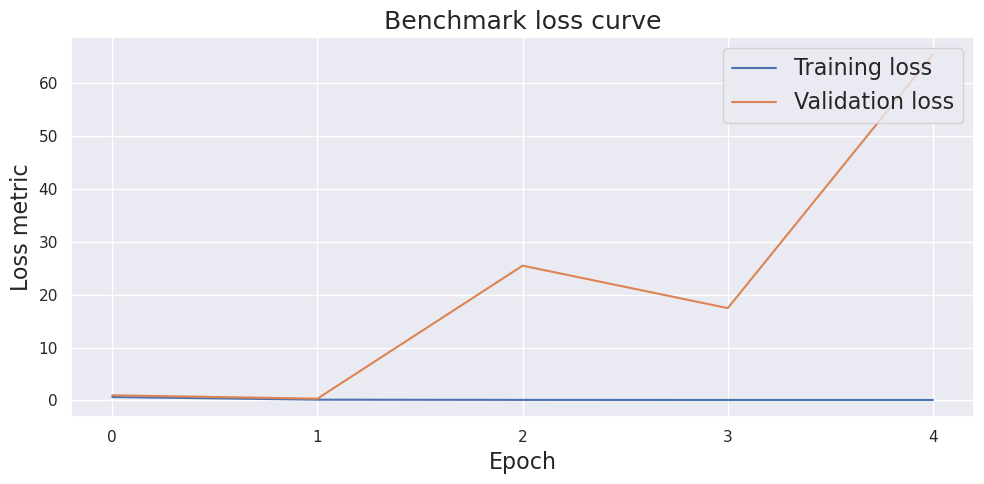

In [24]:
# Benchmark model
plot_loss_curve("benchmark_logs/lightning_logs/version_0/", title="Benchmark loss curve")

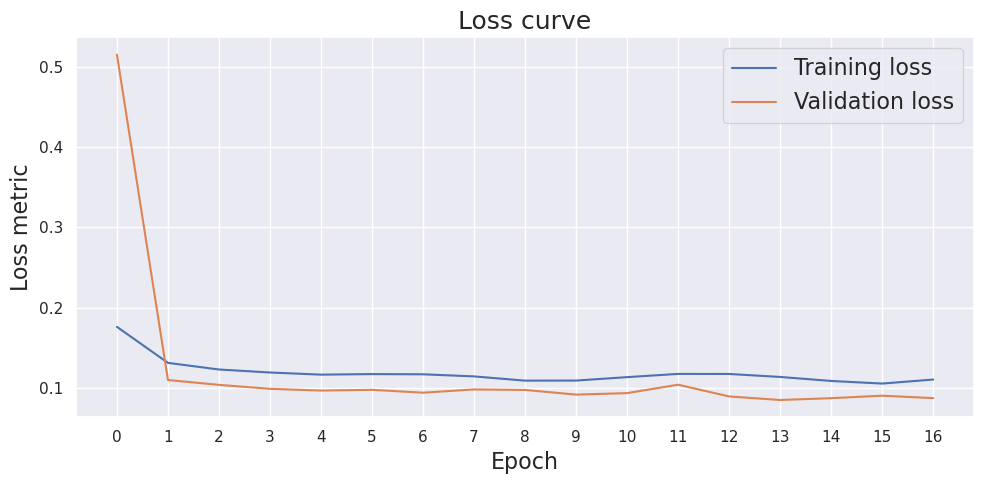

In [37]:
# Vgg-16
plot_loss_curve("vgg16_logs/lightning_logs/version_0/", title="VGG16 loss curve")

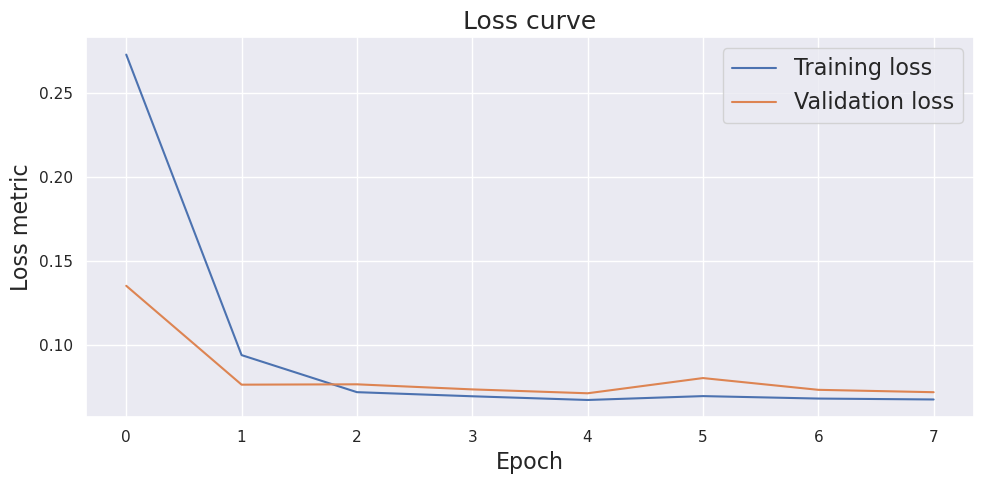

In [38]:
# Meta-learner
plot_loss_curve("meta_logs/lightning_logs/version_0/", title="Stacking model loss curve")

### Performance metrics

In [16]:
# Get performance metrics of each model and return them as a pandas dataframe
# Choice of thresholds is necessary to compute balanced accuracy and F1-score
def get_metrics(true_label, benchmark_preds, vgg16_preds, svc_test_preds, meta_preds, benchmark_thresh, vgg16_thresh, svc_thresh, meta_thresh):
    # Calculate ROC-AUC score
    roc_benchmark = roc_auc_score(true_label, benchmark_preds)
    roc_vgg16 = roc_auc_score(true_label, vgg16_preds)
    roc_svc = roc_auc_score(true_label, svc_test_preds)
    roc_meta = roc_auc_score(true_label, meta_preds)

    # Calculate balanced accuracy score
    bacc_benchmark = balanced_accuracy_score(true_label, benchmark_preds > benchmark_thresh)
    bacc_vgg16 = balanced_accuracy_score(true_label, vgg16_preds > vgg16_thresh)
    bacc_svc = balanced_accuracy_score(true_label, svc_test_preds > svc_thresh)
    bacc_meta = balanced_accuracy_score(true_label, meta_preds > meta_thresh)

    # Calculate f1-score score
    f1_benchmark = f1_score(true_label, benchmark_preds > benchmark_thresh)
    f1_vgg16 = f1_score(true_label, vgg16_preds > vgg16_thresh)
    f1_svc = f1_score(true_label, svc_test_preds > svc_thresh)
    f1_meta = f1_score(true_label, meta_preds > meta_thresh)

    results_df = pd.DataFrame(data=[[roc_benchmark, roc_vgg16, roc_svc, roc_meta], \
                                    [bacc_benchmark, bacc_vgg16, bacc_svc, bacc_meta], \
                                        [f1_benchmark, f1_vgg16, f1_svc, f1_meta]], \
                                            index=["AUC", "Balanced accuracy", "F1-score"], \
                                                columns=["Benchmark", f"VGG16"
                                                         , "Densenet169+SVC", f"Stacking model"])
    
    return results_df

In [17]:
# Get predictions from every model
def get_predictions_all_models(common_loader, meta_loader):
    # Get predictions from the benchmark CNN
    benchmark_preds = benchmark_trainer.predict(best_benchmark, dataloaders=common_loader)
    benchmark_preds = np.hstack([torch.sigmoid(pred.squeeze(1)).detach().cpu().numpy() for pred in benchmark_preds])

    # Get predictions from VGG16
    vgg16_preds = vgg16_trainer.predict(best_vgg16, dataloaders=common_loader)
    vgg16_preds = np.hstack([torch.sigmoid(pred.squeeze(1)).detach().cpu().numpy() for pred in vgg16_preds])

    # Get predictions from SVM
    test_features = get_densenet_predictions(common_loader, densenet_model, device)
    svc_preds = svc_pipe.predict_proba(test_features)[:, 1]

    # Get predictions from the meta-learner
    meta_preds = meta_trainer.predict(best_meta, dataloaders=meta_loader)
    meta_preds = np.hstack([torch.sigmoid(pred).squeeze(1, 2).detach().cpu().numpy() for pred in meta_preds])

    return benchmark_preds, vgg16_preds, svc_preds, meta_preds

#### Metrics on validation set

In [18]:
benchmark_val_preds, vgg16_val_preds, svc_val_preds, meta_val_preds = get_predictions_all_models(val_loader, meta_val_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 13/13 [01:41<00:00,  7.79s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [28]:
# Get the best threshold for classification
def get_best_threshold(y_true, preds):
    fpr, tpr, thresholds = roc_curve(y_true, preds)
    # Calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # Locate the index of the largest g-mean (geometric mean of sensitivity and specificity)
    ix = np.argmax(gmeans)
    print("Best Threshold=%f, G-Mean=%.3f" % (thresholds[ix], gmeans[ix]))

In [29]:
# Best threshold of benchmark
get_best_threshold(np.array(val_data["Label"]), benchmark_val_preds)

Best Threshold=0.398405, G-Mean=0.782


In [30]:
# Best threshold of VGG16
get_best_threshold(np.array(val_data["Label"]), vgg16_val_preds)

Best Threshold=0.499185, G-Mean=0.948


In [31]:
# Best threshold of SVC
get_best_threshold(np.array(val_data["Label"]), svc_val_preds)

Best Threshold=0.862378, G-Mean=0.943


In [32]:
# Best threshold of stacking model
get_best_threshold(np.array(val_data["Label"]), meta_val_preds)

Best Threshold=0.628548, G-Mean=0.959


In [85]:
results_val = get_metrics(np.array(val_data["Label"]), benchmark_val_preds, vgg16_val_preds, svc_val_preds, meta_val_preds, 0.4, 0.5, 0.86, 0.63)
results_val

,Benchmark,VGG16,Densenet169+SVC,Stacking model
AUC,0.852208,0.981158,0.984053,0.986934
Balanced accuracy,0.778334,0.947247,0.943385,0.958788
F1-score,0.814032,0.967014,0.962963,0.971254


In [86]:
# Plotting the validation results
fig =  ff.create_table(results_val.applymap("{0:.4f}".format), index=True)
fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
    font={"size": 18}
)
fig.show()

#### Metrics on test set

In [19]:
benchmark_test_preds, vgg16_test_preds, svc_test_preds, meta_test_preds = get_predictions_all_models(test_loader, meta_test_loader)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 5/5 [00:34<00:00,  6.94s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [20]:
results_test = get_metrics(np.array(test_data["Label"]), benchmark_test_preds, vgg16_test_preds, svc_test_preds, meta_test_preds, 0.4, 0.5, 0.86, 0.63)
results_test

,Benchmark,VGG16,Densenet169+SVC,Stacking model
AUC,0.851512,0.921543,0.874578,0.940226
Balanced accuracy,0.793590,0.798291,0.754274,0.796154
F1-score,0.836173,0.882629,0.861079,0.881594


In [24]:
# Plotting the test results
fig =  ff.create_table(results_test.applymap("{0:.4f}".format), index=True)
fig.update_layout(
    autosize=False,
    width=1000,
    height=400,
    font={"size": 18}
)
fig.show()

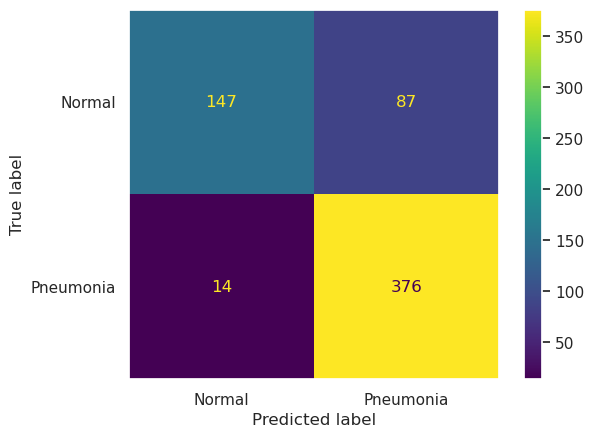

In [72]:
# Confusion matrix of the stacking model predictions on the test set
conf_matrix = confusion_matrix(np.array(test_data['Label']), meta_test_preds > 0.63, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Pneumonia"])
disp.plot()
plt.grid(False)
plt.show()

### ROC curves

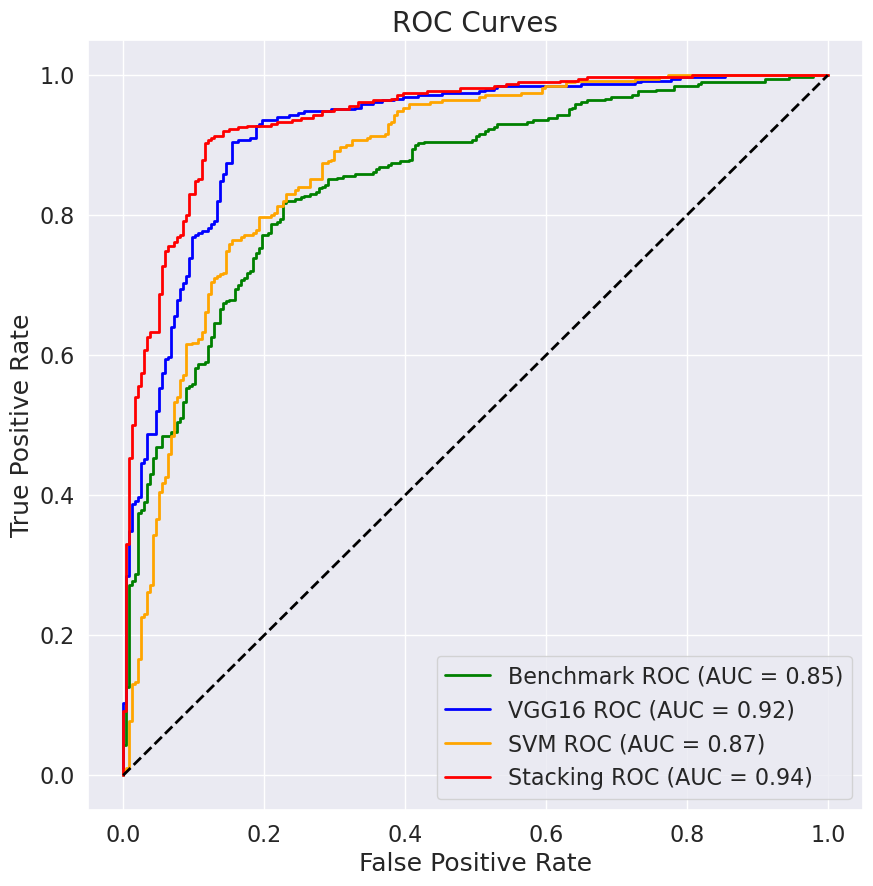

In [126]:
# Calculate ROC AUC metric for each model
roc_benchmark = roc_auc_score(np.array(test_data["Label"]), benchmark_test_preds)
roc_vgg16 = roc_auc_score(np.array(test_data["Label"]), vgg16_test_preds)
roc_svc = roc_auc_score(np.array(test_data["Label"]), svc_test_preds)
roc_meta = roc_auc_score(np.array(test_data["Label"]), meta_test_preds)

# Calculate ROC curve for each model
fpr_benchmark, tpr_benchmark, _ = roc_curve(np.array(test_data["Label"]), benchmark_test_preds)
fpr_vgg16, tpr_vgg16, _ = roc_curve(np.array(test_data["Label"]), vgg16_test_preds)
fpr_svc, tpr_svc, _ = roc_curve(np.array(test_data["Label"]), svc_test_preds)
fpr_meta, tpr_meta, thresholds = roc_curve(np.array(test_data["Label"]), meta_test_preds)

# Visualize ROC curves of models
plt.figure(figsize=(10, 10))
plt.plot(fpr_benchmark, tpr_benchmark, color="green", lw=2, label=f"Benchmark ROC (AUC = {roc_benchmark:.2f})")
plt.plot(fpr_vgg16, tpr_vgg16, color="blue", lw=2, label=f"VGG16 ROC (AUC = {roc_vgg16:.2f})")
plt.plot(fpr_svc, tpr_svc, color="orange", lw=2, label=f"SVM ROC (AUC = {roc_svc:.2f})")
plt.plot(fpr_meta, tpr_meta, color="red", lw=2, label=f"Stacking ROC (AUC = {roc_meta:.2f})")

plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.xlabel("False Positive Rate", fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel("True Positive Rate", fontsize=18)
plt.yticks(fontsize=16)
plt.title("ROC Curves", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### SHAP values

#### VGG16

In [27]:
# Get random 100 observations from the validation set
shap_sample = val_data.sample(100, random_state=42).reset_index(drop=True)
# Choose one random sample from both classes
normal_idx = shap_sample[shap_sample.Label == 0].sample(1, random_state=42).index[0]
pneumonia_idx = shap_sample[shap_sample.Label == 1].sample(1, random_state=42).index[0]

In [28]:
# Define resizing transformation
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
])
# Define normalization transformation
post_transform = transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x * (1 / 255))
    , torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
# Dataloader with normalized samples used as inputs for model
shap_loader = DataLoader(ImageDataset(shap_sample, transform=image_transforms, normalize=True)
                         , shuffle=False
                         , batch_size=100
                         , drop_last=False
                         , num_workers=8
                         )
# Dataloader with not normalized samples used for plotting the image
vis_loader = DataLoader(ImageDataset(shap_sample, transform=image_transforms, normalize=False)
                        , shuffle=False
                        , batch_size=100
                        , drop_last=False
                        , num_workers=8
                        )

In [29]:
# Get batch from each dataloader
X_shap, y_shap = next(iter(shap_loader))
X_vis, y_vis = next(iter(vis_loader))

In [30]:
torch.use_deterministic_algorithms(True, warn_only=True)

background = X_shap[[i for i in range(100) if i not in [normal_idx, pneumonia_idx]]]
test_images = X_shap[[normal_idx, pneumonia_idx]]

# Model returns logits, so sigmoid layer has to be applied
vgg16_pipeline = nn.Sequential(best_vgg16.model, nn.Sigmoid())

# Explain the model with expected gradients
e = shap.GradientExplainer(vgg16_pipeline, background)

In [31]:
# Calculate SHAP values for test images
shap_values = e.shap_values(test_images, nsamples=500)

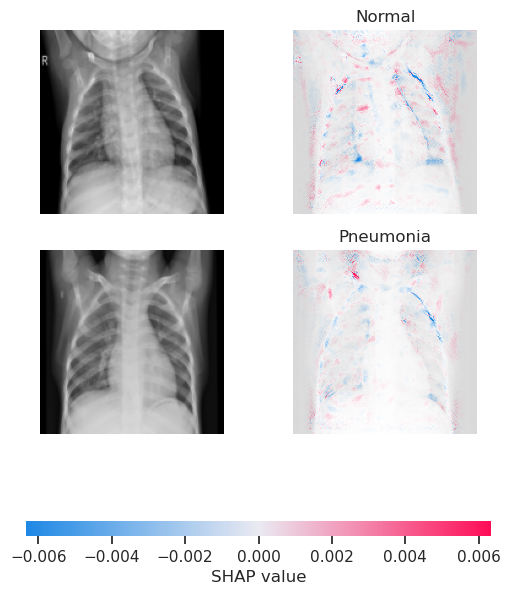

In [32]:
# Plot SHAP values
labels = np.array(["Normal", "Pneumonia"]).reshape((2, 1))
shap.image_plot(np.transpose(shap_values, (0, 2, 3, 1)), torch.permute(X_vis[[normal_idx, pneumonia_idx]], (0, 2, 3, 1)).detach().cpu().numpy(), labels=labels)

#### Stacking model

In [36]:
# Get random 100 samples from validation set of the meta-learner
shap_features = []
shap_targets = []

for X_shap, y_shap in meta_val_loader:
    shap_features.append(X_shap)
    shap_targets.append(y_shap)

shap_features = torch.cat(shap_features[:10], dim=0)
shap_targets = torch.cat(shap_targets[:10], dim=0)

shap_features = shap_features[torch.randperm(shap_features.size(0))[:100]]

In [38]:
# Model returns logits, so sigmoid layer has to be applied
meta_pipeline = nn.Sequential(best_meta.model, nn.Sigmoid())

# Explain the model with deep explainer
explainer = shap.DeepExplainer(meta_pipeline, data=shap_features.detach())

# Calculate SHAP values for the meta-learner sample inputs
shap_values = explainer.shap_values(shap_features.detach(), check_additivity=False)
shap_values = np.sum(shap_values, axis=1)

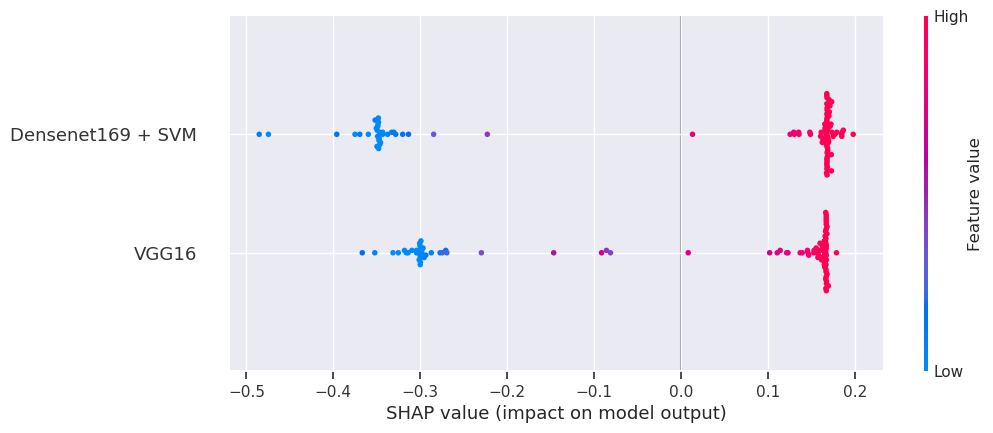

In [39]:
# Plot SHAP values
shap.summary_plot(shap_values, shap_features.squeeze(1).detach().cpu().numpy(), feature_names=["VGG16", "Densenet169 + SVM"], show=False, title = "Shapley values on test sample")
plt.gcf().set_size_inches(12, 6)
plt.show()